# Outline

* Definition of Function
* Data Set
* Setup Imports and Variables
* Data Exploration
* Data Preprocessing
* Gradient Boosting Tree (GBDT)
* Random Forest (RT)
* Multi Layer Perceptron (MLP)
* Performance Comparison

# Description
In order to manage passenger needs as well as reduce greenhouse gas emissions and limit traffic congestion in growing cities, good transportation models are crucial. Traditional transportation models like multinomial logit random utility models (RUMs) are commonly used to predict passenger mode choices. However, with the rise of large datasets and machine learning techniques, more sophisticated methods can provide higher accuracy and insight into travel behavior. The Paper by Hillel et al. (2018) predicts passenger mode choices using Gradient Boosting Trees (GBDT). It is based on a dataset that contains individual trip records, extended with travel trajectories and real time estimates for various travel modes in London. The GBDT model in the paper showed promising results.

In [31]:
#import libraries
import pandas as pd
import numpy as np
import google.colab.drive as drive
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Define number of bins for histogram plots
bin_size = 10

# Set a flag to control whether to run the hyperparameter search
run_hyperparameter_search_RF= False
run_hyperparameter_search_MLP = False

## Definition of Functions

In [32]:
def plot_stacked_percentage_bar_chart(df, feature, target):

    def format_label(label):
        return ' '.join(word.capitalize() for word in label.split('_'))

    # Create a crosstab of the specified feature against the target
    crosstab = pd.crosstab(df[feature], df[target])

    # Normalize the crosstab to sum to 1
    crosstab_norm = crosstab.div(crosstab.sum(1).astype(float), axis=0)

    # Automatically generate title and labels with formatting
    title = f'Distribution of {format_label(target)} by {format_label(feature)}'

    # Plot the normalized crosstab and capture the Axes object
    ax = crosstab_norm.plot(kind='bar', stacked=True, figsize=(10, 6), title=title)

    # Set axis labels
    ax.set_xlabel(format_label(feature))
    ax.set_ylabel(format_label(target))

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

## Data Exploration

In [33]:
drive.mount('/content/drive')
data_file_path = '/content/drive/MyDrive/londondataset.csv'
df_train = pd.read_csv(data_file_path)

pd.set_option('display.max_columns', None)
df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,travel_year,travel_month,travel_date,day_of_week,start_time_linear,age,female,driving_license,car_ownership,distance,dur_walking,dur_cycling,dur_pt_total,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int_total,dur_pt_int_waiting,dur_pt_int_walking,pt_n_interchanges,dur_driving,cost_transit,cost_driving_total,cost_driving_fuel,cost_driving_con_charge,driving_traffic_percent
0,0,0,0,0,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,10.000000,56,1,1,2,778,0.218056,0.092222,0.149444,0.134444,0.0,0.016667,0.0,0.0,0.0,0,0.052222,1.5,0.14,0.14,0.0,0.111702
1,1,0,0,1,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,13.000000,56,1,1,2,778,0.188889,0.061944,0.168056,0.109444,0.0,0.055556,0.0,0.0,0.0,0,0.059444,1.5,0.15,0.15,0.0,0.112150
2,2,0,0,2,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,17.000000,56,1,1,2,4562,1.037778,0.355833,0.412222,0.203056,0.0,0.210278,0.0,0.0,0.0,0,0.236667,1.5,0.79,0.79,0.0,0.203052
3,3,0,0,3,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,17.350000,56,1,1,2,4562,1.039444,0.384444,0.463611,0.205556,0.0,0.258611,0.0,0.0,0.0,0,0.233333,1.5,0.78,0.78,0.0,0.160714
4,4,0,1,2,drive,HBO,Petrol_Car,dis,1.0,1,2012,4,1,7,19.583333,54,0,1,2,4562,1.037778,0.355833,0.391389,0.203056,0.0,0.189444,0.0,0.0,0.0,0,0.229167,1.5,0.78,0.78,0.0,0.130909


In [34]:
df_train.dtypes

,0
trip_id,int64
household_id,int64
person_n,int64
trip_n,int64
travel_mode,object
purpose,object
fueltype,object
faretype,object
bus_scale,float64
survey_year,int64


**Overview of datatypes indicates possible necessity of preprocessing steps (one-hot)**

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81086 entries, 0 to 81085
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   trip_id                  81086 non-null  int64  
 1   household_id             81086 non-null  int64  
 2   person_n                 81086 non-null  int64  
 3   trip_n                   81086 non-null  int64  
 4   travel_mode              81086 non-null  object 
 5   purpose                  81086 non-null  object 
 6   fueltype                 81086 non-null  object 
 7   faretype                 81086 non-null  object 
 8   bus_scale                81086 non-null  float64
 9   survey_year              81086 non-null  int64  
 10  travel_year              81086 non-null  int64  
 11  travel_month             81086 non-null  int64  
 12  travel_date              81086 non-null  int64  
 13  day_of_week              81086 non-null  int64  
 14  start_time_linear     

The dataset does not have any missing values, so the analysis can be carried out without handling any gaps in the data.



In [36]:
df_train.describe()

,trip_id,household_id,person_n,trip_n,bus_scale,survey_year,travel_year,travel_month,travel_date,day_of_week,start_time_linear,age,female,driving_license,car_ownership,distance,dur_walking,dur_cycling,dur_pt_total,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int_total,dur_pt_int_waiting,dur_pt_int_walking,pt_n_interchanges,dur_driving,cost_transit,cost_driving_total,cost_driving_fuel,cost_driving_con_charge,driving_traffic_percent
count,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.00000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000,81086.000000
mean,40542.500000,8709.504588,0.803628,1.535284,0.645876,1.985719,2013.18124,6.694201,15.357300,3.955677,13.834781,39.462065,0.526478,0.617061,0.980798,4605.264152,1.129074,0.362129,0.466878,0.160415,0.090128,0.171894,0.044032,0.037067,0.006966,0.369065,0.282131,1.563212,1.903208,0.832049,1.071159,0.335693
std,23407.656301,5070.378464,1.055050,1.771189,0.472069,0.814416,0.90097,3.332166,8.744826,1.936428,4.456804,19.227273,0.499301,0.486107,0.751780,4782.352976,1.118179,0.352031,0.310061,0.091764,0.177097,0.189836,0.077698,0.065874,0.016861,0.618988,0.252295,1.535197,3.485121,0.822737,3.178036,0.200923
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2012.00000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,77.000000,0.025278,0.006111,0.007500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000278,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20271.250000,4297.000000,0.000000,0.000000,0.000000,1.000000,2012.00000,4.000000,8.000000,2.000000,10.000000,25.000000,0.000000,0.000000,0.000000,1309.000000,0.350556,0.116944,0.225833,0.092500,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.107500,0.000000,0.290000,0.280000,0.000000,0.173339
50%,40542.500000,8662.500000,0.000000,1.000000,1.000000,2.000000,2013.00000,7.000000,15.000000,4.000000,14.000000,38.000000,1.000000,1.000000,1.000000,2814.000000,0.723056,0.232222,0.388611,0.143889,0.000000,0.111944,0.000000,0.000000,0.000000,0.000000,0.191667,1.500000,0.570000,0.540000,0.000000,0.305966
75%,60813.750000,13035.000000,1.000000,2.000000,1.000000,3.000000,2014.00000,10.000000,23.000000,6.000000,17.000000,52.000000,1.000000,1.000000,2.000000,6175.000000,1.513889,0.484722,0.642778,0.211389,0.100000,0.249722,0.083333,0.073889,0.000000,1.000000,0.368889,2.400000,1.290000,1.090000,0.000000,0.482323
max,81085.000000,17615.000000,9.000000,18.000000,1.000000,3.000000,2015.00000,12.000000,31.000000,7.000000,23.933333,99.000000,1.000000,1.000000,2.000000,40941.000000,9.278333,3.051944,2.735278,1.188889,1.466667,2.147222,0.865278,0.837222,0.179167,4.000000,2.060833,13.490000,17.160000,10.090000,10.500000,1.250000


The above analysis provides a foundational understanding of the data. In the following steps, various visualizations will be created, and feature engineering will be carried out to prepare the data for machine learning. This includes transforming categorical variables into dummy variables (one-hot encoding), as there is no inherent order among them.


### Day of the Week

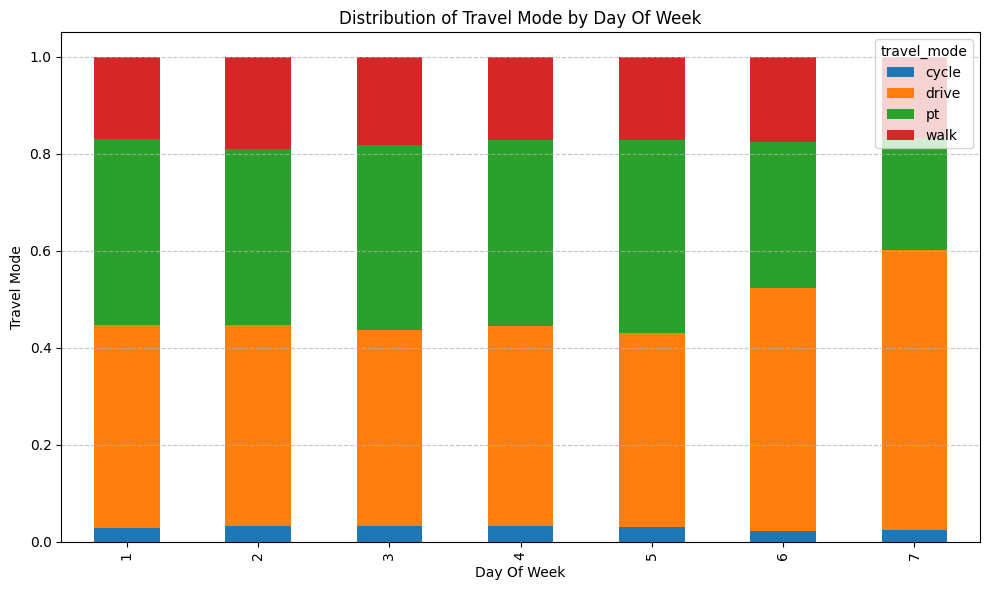

In [37]:
plot_stacked_percentage_bar_chart(df_train, feature='day_of_week', target='travel_mode')

 It is evident that public transportation is used more frequently during
weekdays than on weekends. This could be because public transportation is primarily utilized for commuting purposes, while on weekends, people often prefer to drive for activities like shopping. Analyzing the reasons behind travel choices will provide further insight into this trend.

### Purpose

Prepare to map purpose from a string to a number representation:

*   **B**  - **Business**: Travel related to business or work purposes.
*   **HBE** - **Home-Based Education**: Travel from home to educational institutions (like school or university) or back home.
*   **HBO** - **Home-Based Other**: Travel originating from home for other activities (e.g., appointments, errands).
*   **HBW** - **Home-Based Work**: Commuting from home to work or from work back to home.
*   **NHBO** - **Non-Home-Based Other**: Travel not originating from home for non-work or non-education-related purposes, such as leisure or social activities.




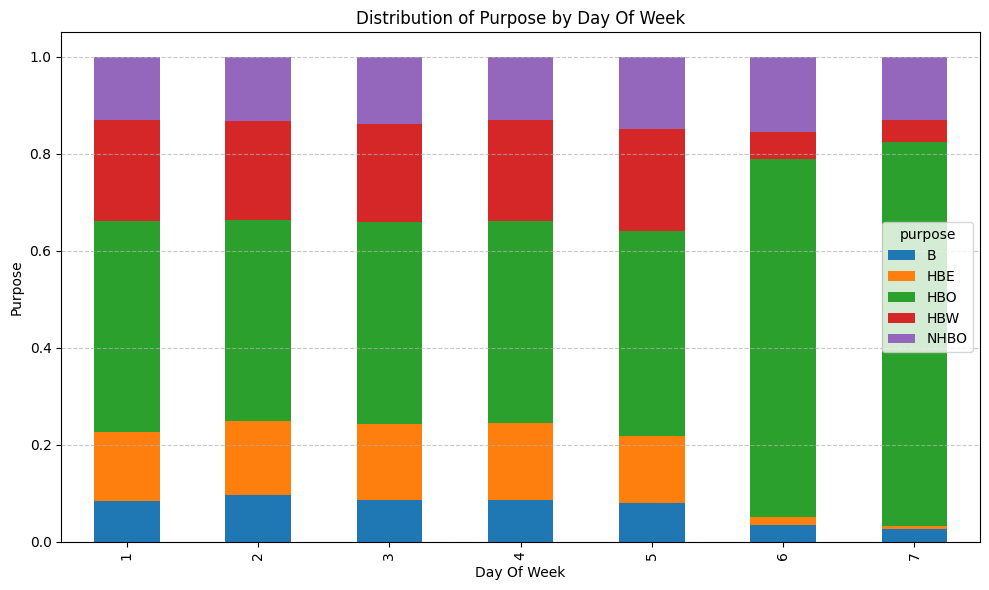

In [38]:
plot_stacked_percentage_bar_chart(df_train, feature='day_of_week', target='purpose')

As expected, work, business, and education-related trips (such as HBW, B, and HBE) are less frequent during the weekend, as most people are off from work or school during this time. On the other hand, HBO trips (related to other home-based activities) tend to increase on weekends, as people engage in leisure, shopping, or social activities.

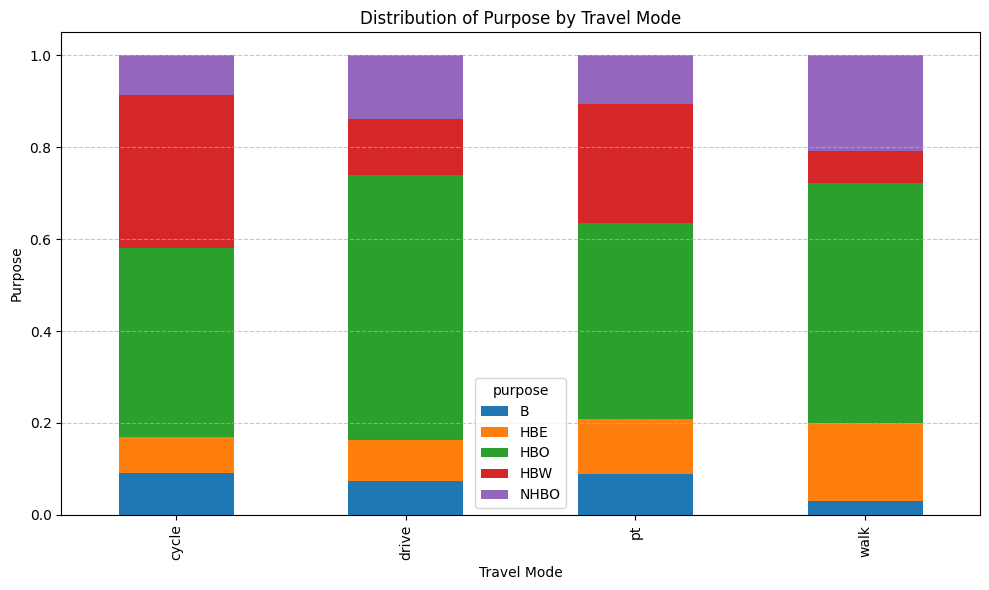

In [39]:
plot_stacked_percentage_bar_chart(df_train, feature='travel_mode', target='purpose')

This plot describes the reason for using certain travel modes. For instance, home-base-other purposes like appointments are more often reached by driving than other modes. Furthermore, people don't walk when doing business. However, for NHBO (maybe walks from work to break and back) are often walked. Cycling is mostly used for commuting to work or other appointments.


### Age

Text(0, 0.5, 'Density')

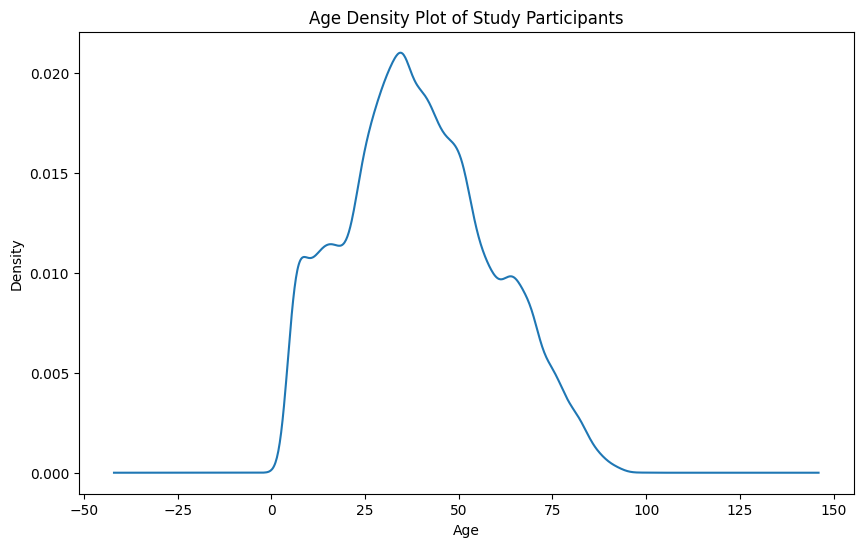

In [40]:
df_train['age'].plot(kind='kde', figsize=(10, 6))
plt.title('Age Density Plot of Study Participants')
plt.xlabel('Age')
plt.ylabel('Density')

Most of the study parcitipants are between 25 and 55 with a peak around 40 years. There are very few very young participants which makes sense. Teenagers and young adults appear to be equally represented.


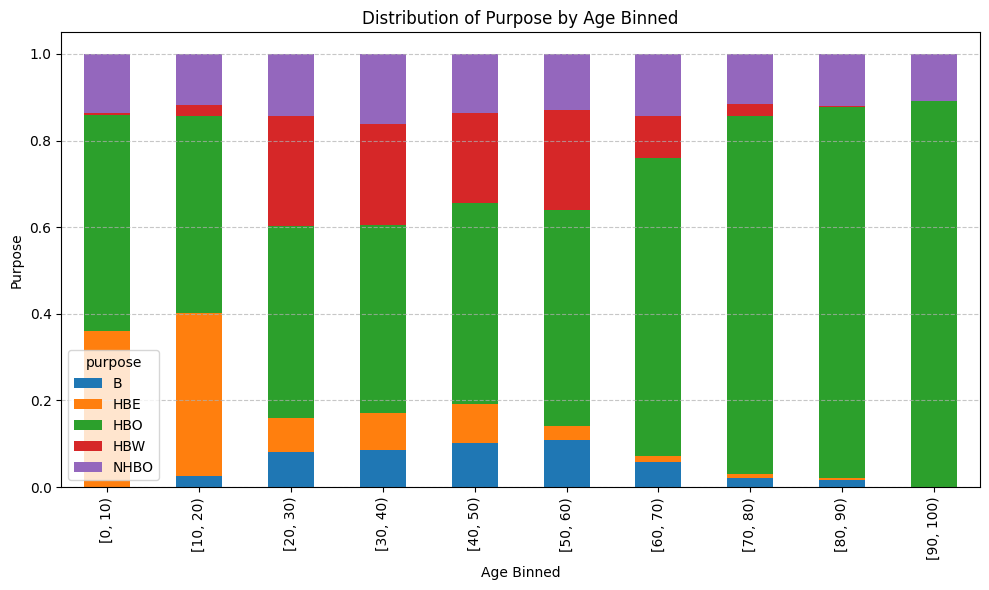

In [41]:
age_bins = range(0, 101, 10)  # Creates bins [0, 10), [10, 20), ..., [90, 100]
df_train['age_binned'] = pd.cut(df_train['age'], bins=age_bins, right=False)
plot_stacked_percentage_bar_chart(df_train, feature='age_binned', target='purpose')

This distribution provides insights of travel purposes by age. Education-related trips are mainly done by young people up to 20 years. Few education-related trips are done by older people than that.
HBO (activities etc.) are similarily distributed from the ages 0 to around 60, rising above that age. Older people mostly travel for HBO reasons and only very few still work. Travel because of work do mostly people between 20 and 60 years old.  

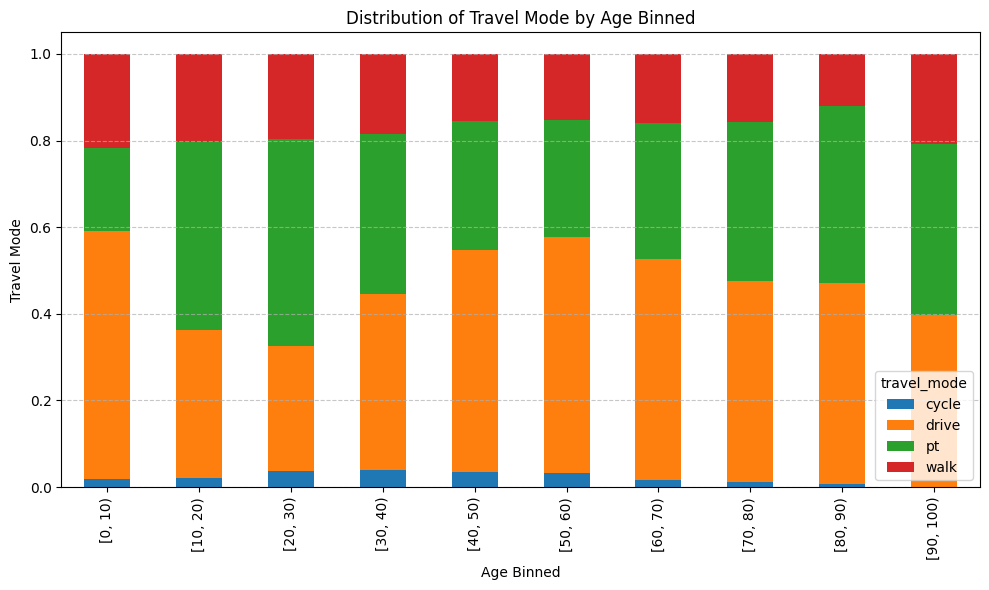

In [42]:
plot_stacked_percentage_bar_chart(df_train, feature='age_binned', target='travel_mode')

Infants under 10 are mostly driven around by their parents. Smaller amounts walk or use public transit. People between 20 and 30 mostly use public transit. With rising age, people tend to drive around and use less public transit up to an age of 60. After that, public transit becomes more popular again besides driving. Cycling is the smallest proportion of all modes across all ages.

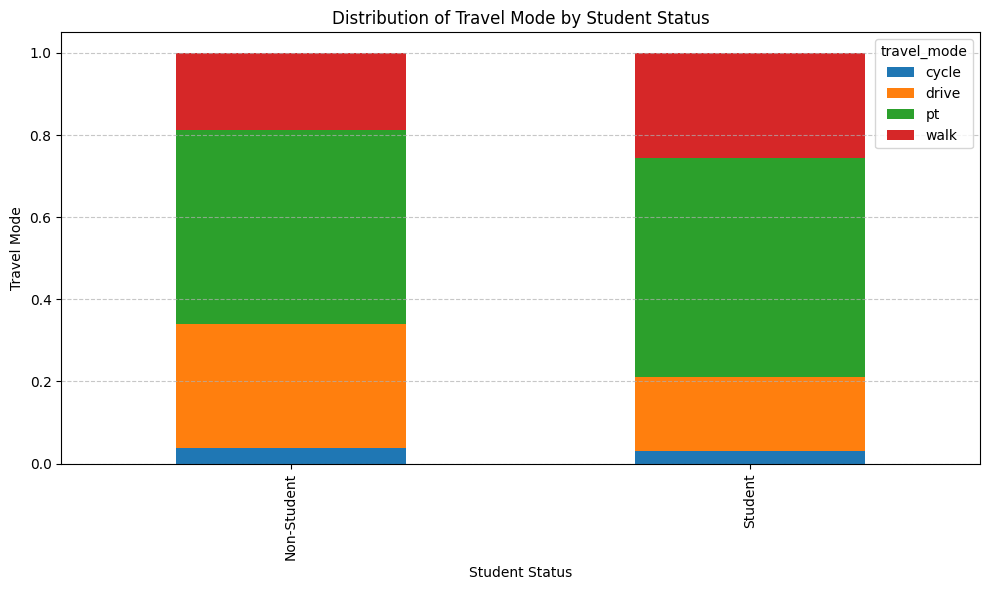

In [43]:
# Identify participants in the age group 20-30 who have traveled for education
df_train['unique_id'] = df_train['household_id'].astype(str) + '_' + df_train['person_n'].astype(str)
edu_participants = df_train[(df_train['age_binned'].astype(str) == '[20, 30)') & (df_train['purpose'] == 'HBE')]['unique_id']


# Create a new column 'student_status'
df_train['student_status'] = 'Non-Student'
df_train.loc[(df_train['unique_id'].isin(edu_participants)), 'student_status'] = 'Student'

plot_stacked_percentage_bar_chart(df_train[df_train['age_binned'].astype(str) == '[20, 30)'], 'student_status', 'travel_mode')

Out of interest, the distribution of student status within the dataset was explored to gain a deeper understanding of potential demographic influences on travel mode choice. While this investigation was not directly tied to the primary objectives of this study, it provided additional context regarding the dataset's composition. By binning the purpose of the trip by age as well as the travel mode by age participants in the age group 20-30 who have traveled for education can be identified. These individuals are assumed to have student status. The exploration reveals that students are more likely to take public transit or walk than non-students, who are more likely to take the car than students. The proportion of cycling is the fewest of the travel modes and similar for both observed groups.

### Travel Month

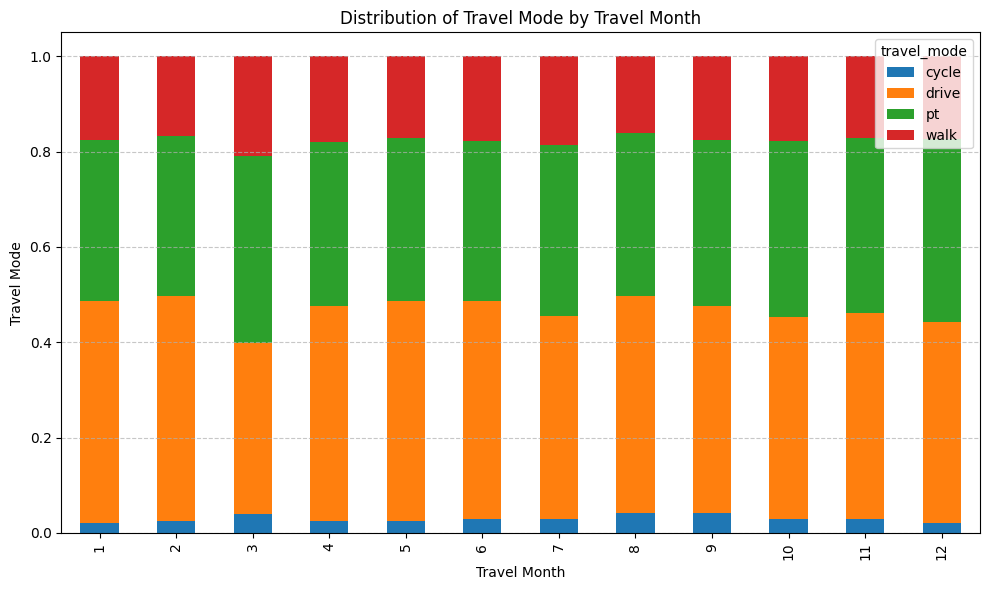

In [44]:
plot_stacked_percentage_bar_chart(df_train, feature='travel_month', target='travel_mode')

This distribution does not reveal any noticable insights. However, it is surprising that public transit or walking does not decrease over the winter months and incease in the summer months. Only a tiny increase in cycling shows in the summer months August and September.

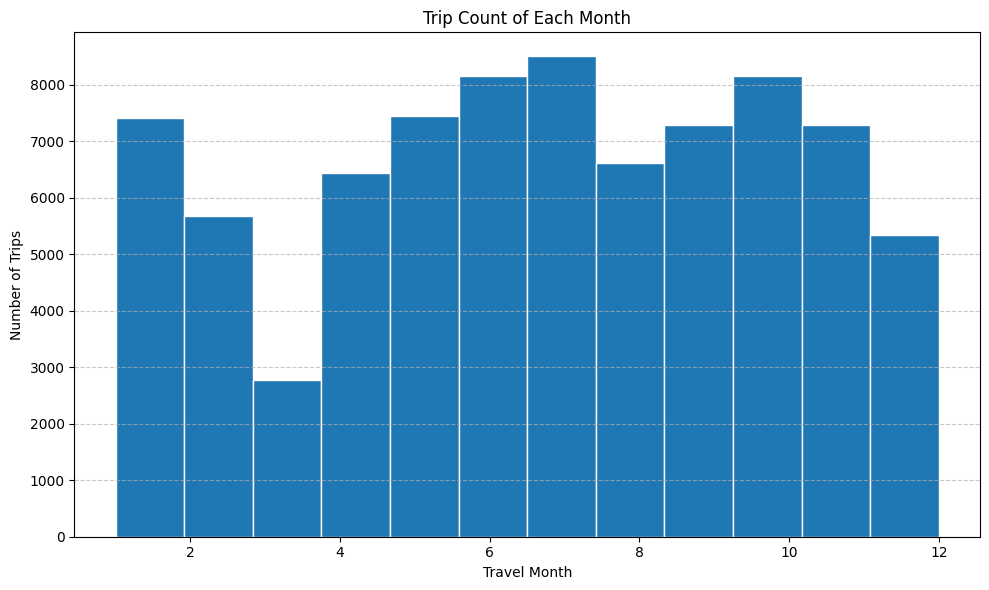

In [45]:
ax = df_train['travel_month'].plot.hist(alpha=1, bins=12, figsize=(10, 6), edgecolor='white' )

# Set axis labels
ax.set_xlabel('Travel Month')
ax.set_ylabel('Number of Trips')

# Set title
ax.set_title('Trip Count of Each Month')

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

The trip count varies monthly. The month of March stands out with very few trip counts. Further exploration revealed this pattern shows in every observed year with especially low proportions of the travel mode car. Since in March is a Spring break, this could be assumed a reason for the minimal number of trips. The true reason however, remains unclear.

### Distance

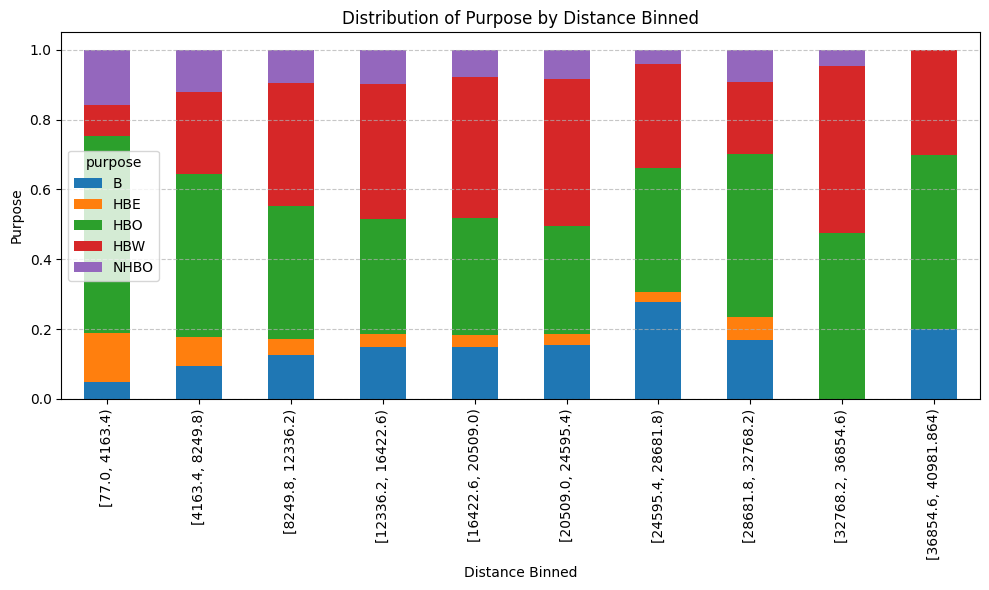

In [46]:
df_train['distance_binned'] = pd.cut(df_train['distance'], bins=10, right=False)
plot_stacked_percentage_bar_chart(df_train, feature='distance_binned', target='purpose')

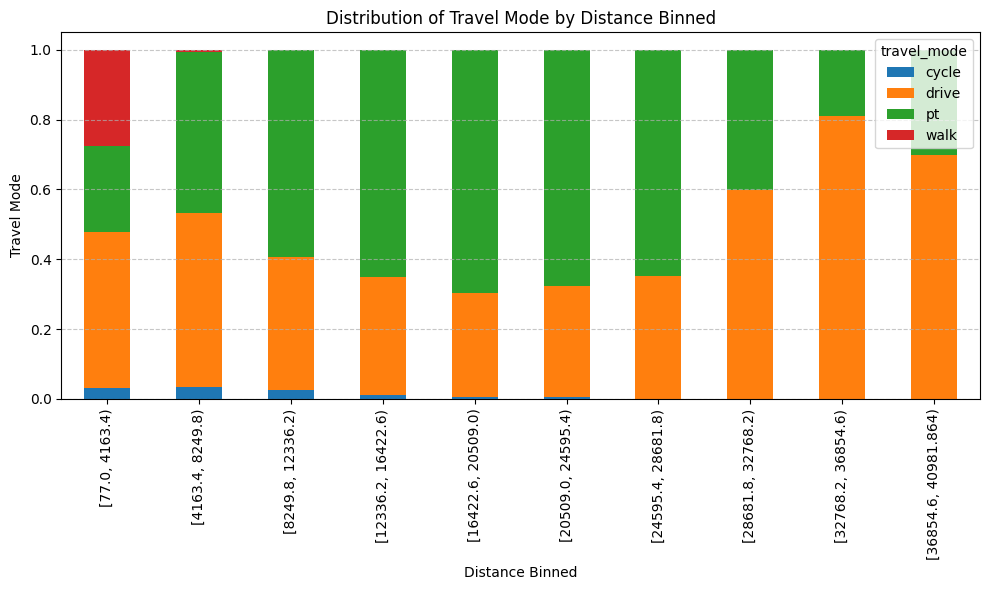

In [47]:
plot_stacked_percentage_bar_chart(df_train, feature='distance_binned', target='travel_mode')

This Bar-Chart shows that distances between around 8 km and 28 km are undertaken using public transit. Trips longer than 28 km are mostly undertaken by driving. Walking trips are limited to distances around 4 km. Cycling is limited to distances around 12 km with few exceptions.

### Transit Costs

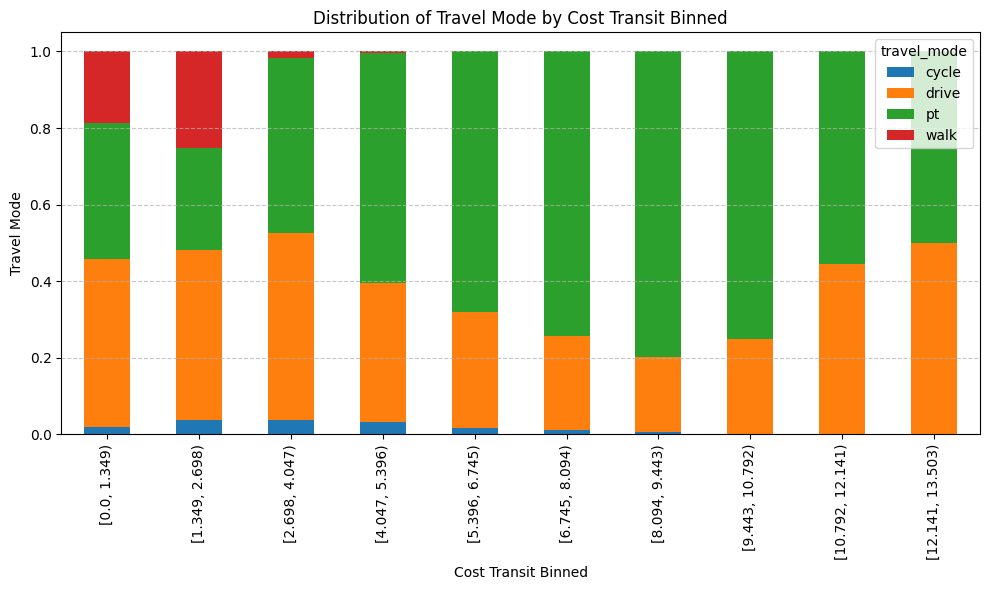

In [48]:
df_train['cost_transit_binned'] = pd.cut(df_train['cost_transit'], bins=10, right=False)
plot_stacked_percentage_bar_chart(df_train, feature='cost_transit_binned', target='travel_mode')

These explorations reveal that the bar chart of transit cost – travel mode and the bar chart of distance – travel mode looks similar. Therefore one could suspect that the features correlate. Plotting distance versus transit cost will reveal more insight

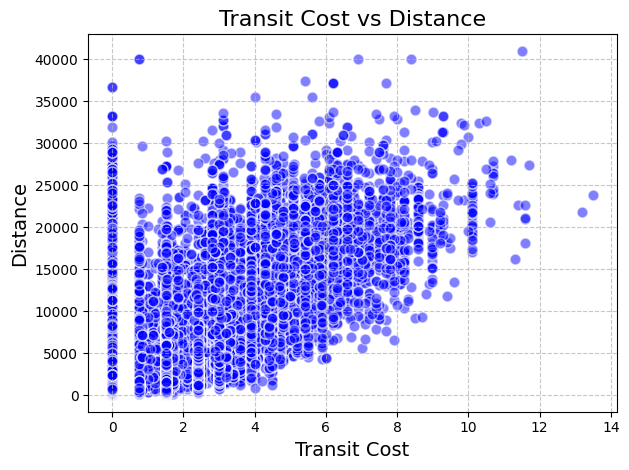

In [49]:
# plt.figure(figsize=(10, 6))
plt.scatter(df_train['cost_transit'], df_train['distance'], alpha=0.5, c='blue', edgecolors='w', s=60)

# Add title and labels
plt.title('Transit Cost vs Distance', fontsize=16)
plt.xlabel('Transit Cost', fontsize=14)
plt.ylabel('Distance', fontsize=14)

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to avoid clipping
plt.tight_layout()

Plotting distance versus transit cost displays a weak linear relation between the two variables, which, however, is too weak, resulting in both features being included in the model.

<module 'google.colab.drive' from '/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'> 0.4416052092839701
<module 'google.colab.drive' from '/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'> 0.352773598401697
<module 'google.colab.drive' from '/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'> 0.17596132501294923
<module 'google.colab.drive' from '/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'> 0.029659867301383716


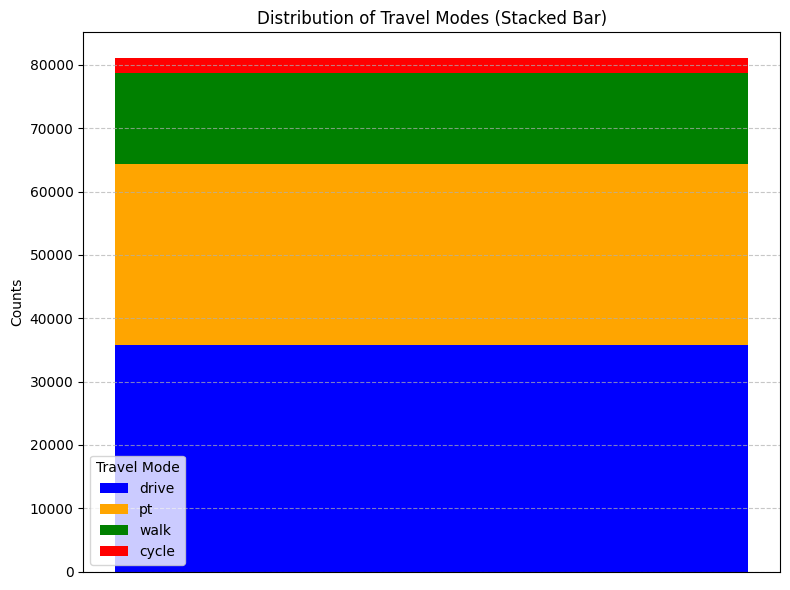

In [50]:
travel_mode_counts = df_train['travel_mode'].value_counts()

# Create a list of colors for each travel mode
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plotting a single stacked bar chart
plt.figure(figsize=(8, 6))

# Initialize the bottom position for stacking
bottom = 0

# Plot each segment of the bar
for i, (mode, count) in enumerate(travel_mode_counts.items()):
    plt.bar(
        x=['Travel Modes'],  # Only one bar
        height=count,
        color=colors[i],
        width=0.6,
        bottom=bottom,
        label=mode
    )
    print(drive,count/travel_mode_counts.sum())
    # Update the bottom position for the next segment
    bottom += count

plt.ylabel('Counts')
plt.title('Distribution of Travel Modes (Stacked Bar)')
plt.xticks([])
plt.legend(title='Travel Mode')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

Driving overweighs the other observed travel modes used per trip, with 44 % of the total, being directly followed by public transit (35 %). 17,5 % of all trips are untertaken by walking and only 2.9 % are done using the bicycle.

## Data Preprocessing

To bring all values into a form suitable for Machine Learning with Decision Trees:

* Categorical Data: One-hot encoding
* Temporal Data:
  - Apply sine and cosine transformations to temporal data.

In [51]:
# Create empty dataframe to start with
df_train_preprocessed = pd.DataFrame()

### Add categorical features with one-hot encoding

In [52]:
categorical_features = ['purpose', 'fueltype', 'faretype']
df_train_categorical = df_train[categorical_features]
df_train_preprocessed = pd.get_dummies(df_train_categorical, prefix=categorical_features)

### Add continuous features

In [53]:
continuous_features = ['age', 'distance', 'cost_transit', 'bus_scale', 'dur_walking', 'dur_cycling', 'dur_pt_total',
                          'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int_total', 'dur_pt_int_waiting',
                          'dur_pt_int_walking', 'pt_n_interchanges', 'dur_driving', 'cost_driving_total',
                          'cost_driving_fuel', 'cost_driving_con_charge', 'driving_traffic_percent']
df_train_preprocessed[continuous_features] = df_train[continuous_features]

### Temporal features

In [54]:
temporal_features = ['travel_month', 'start_time_linear', 'day_of_week']
df_train_preprocessed[temporal_features] = df_train[temporal_features]

# Include travel_year for splitting the data set into training and test data
df_train_preprocessed['travel_year'] = df_train['travel_year']

### Target

In [55]:
df_train_preprocessed['target'] = df_train['travel_mode']

### Temporal Preprocessing - Sine and Cosine transformations


In [56]:
for feature in temporal_features:
    df_train_preprocessed[feature + '_sin'] = np.sin(2 * np.pi * df_train[feature] / df_train[feature].max())
    df_train_preprocessed[feature + '_cos'] = np.cos(2 * np.pi * df_train[feature] / df_train[feature].max())

### Training Data - Holdout Test Data Split


In [57]:
# Create a new column to define the train/test split
df_train_preprocessed['split'] = 'train'
df_train_preprocessed.loc[
    (df_train_preprocessed['travel_year'] == 2014) & (df_train_preprocessed['travel_month'] >= 4), 'split'
] = 'test'
df_train_preprocessed.loc[
    df_train_preprocessed['travel_year'] > 2014, 'split'
] = 'test'

# Split into training and testing datasets
df_train_data = df_train_preprocessed[df_train_preprocessed['split'] == 'train']
df_test_data = df_train_preprocessed[df_train_preprocessed['split'] == 'test']

# Drop the 'split' column as it's not needed for the model
df_train_data = df_train_data.drop(columns=['split','travel_year'])
df_test_data = df_test_data.drop(columns=['split','travel_year'])

# Separate features and target
X_train = df_train_data.drop(columns=['target'])
X_test = df_test_data.drop(columns=['target'])

# Encode the target column
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train_data['target'])
y_test = label_encoder.transform(df_test_data['target'])

### Raw Data Set

In [58]:
# Create a subset of the full dataset that only contains the raw data
columns_to_delete = [
    'dur_walking', 'dur_cycling', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_access',
    'dur_pt_int_total', 'dur_pt_total', 'cost_transit', 'pt_n_interchanges',
    'dur_driving', 'cost_driving_total', 'cost_driving_con_charge', 'driving_traffic_percent'
]

X_train_raw = X_train.drop(columns=columns_to_delete)
X_test_raw = X_test.drop(columns=columns_to_delete)

## Gradient Boosting Tree (GBDT)

In [59]:
model = XGBClassifier(
    n_estimators=1440,
    max_depth=6,
    learning_rate=0.01,
    gamma=0.2871,
    min_child_weight=31,
    subsample=0.55,
    colsample_bytree=0.6,
    colsample_bylevel=0.8,
    reg_alpha=0.006864,
    reg_lambda=2.057,
    max_delta_step=1,
    objective='multi:softprob',
    eval_metric='mlogloss'
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

model_raw = XGBClassifier(
    n_estimators=1440,
    max_depth=6,
    learning_rate=0.01,
    gamma=0.2871,
    min_child_weight=31,
    subsample=0.55,
    colsample_bytree=0.6,
    colsample_bylevel=0.8,
    reg_alpha=0.006864,
    reg_lambda=2.057,
    max_delta_step=1,
    objective='multi:softprob',
    eval_metric='mlogloss'
)
model_raw.fit(X_train_raw, y_train, eval_set=[(X_test_raw, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.2871, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=6,
              max_leaves=None, min_child_weight=31, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1440,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

###GBDT: Predicting

In [60]:
# Predict class labels (with argmax for multi-class classification)
y_pred = model.predict(X_test)
y_pred_raw = model_raw.predict(X_test_raw)

y_prob = model.predict_proba(X_test)  # Returns probabilities for each class
y_prob_raw = model_raw.predict_proba(X_test_raw)  # Same for raw data

### GBDT: Performance Metrics

In [61]:
# Negative Log-Likelihood (NLL)
nll = log_loss(y_test, y_prob)
nll_raw = log_loss(y_test, y_prob_raw)

# Expected Simulation Error (ESE)
ese = 1 - np.mean([probs[true_class] for probs, true_class in zip(y_prob, y_test)])
ese_raw = 1 - np.mean([probs[true_class] for probs, true_class in zip(y_prob_raw, y_test)])

# Multiclass Classification Error (CE)
ce = 1 - accuracy_score(y_test, y_pred)
ce_raw = 1 - accuracy_score(y_test, y_pred_raw)

print(f"Negative Log-Likelihood (NLL): {nll}")
print(f"Expected Simulation Error (ESE): {ese}")
print(f"Multiclass Classification Error (CE): {ce}")
print(f"________________________________________________________________________")
print(f"Negative Log-Likelihood raw (NLL): {nll_raw}")
print(f"Expected Simulation Error raw (ESE): {ese_raw}")
print(f"Multiclass Classification Error raw (CE): {ce_raw}")

Negative Log-Likelihood (NLL): 0.6858852912331456
Expected Simulation Error (ESE): 0.37138205766677856
Multiclass Classification Error (CE): 0.26648936170212767
________________________________________________________________________
Negative Log-Likelihood raw (NLL): 0.7457154833453044
Expected Simulation Error raw (ESE): 0.40921837091445923
Multiclass Classification Error raw (CE): 0.29411094224924017


## Random Forest (RF)

###Hyperparameter Search

In [62]:
param_grid = {
    'n_estimators': [200, 800, 1200],
    'max_depth': [2, 6, 15],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

if run_hyperparameter_search_RF:
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring='neg_log_loss'
    )
    grid_search.fit(X_train, y_train)
    print("Best parameters for model (X_train): ", grid_search.best_params_)

**The grid search resulted in the highest value for every parameter. It is therefore likely that the optimal parameters exceed the defined search space and the model is not optimal. Only one grid search for both models due to limited hardware performance.**

###RF: Training

In [63]:
rf_best_params = {
    'n_estimators': 1200,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt'
}

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    **rf_best_params
)

rf_model.fit(X_train, y_train)


rf_model_raw = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    **rf_best_params
)

rf_model_raw.fit(X_train_raw, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1200, n_jobs=-1, random_state=42)

###RF: Predicting

In [64]:
# Predict class labels (for Random Forest)
y_pred = rf_model.predict(X_test)
y_pred_raw = rf_model_raw.predict(X_test_raw)

# Predict probabilities (for Random Forest)
y_prob = rf_model.predict_proba(X_test)
y_prob_raw = rf_model_raw.predict_proba(X_test_raw)

### RF: Performance Metrics

In [65]:
# Negative Log-Likelihood (NLL) for Random Forest
nll_rf = log_loss(y_test, y_prob)
nll_rf_raw = log_loss(y_test, y_prob_raw)

# Expected Simulation Error (ESE) for Random Forest
ese_rf = 1 - np.mean([probs[true_class] for probs, true_class in zip(y_prob, y_test)])
ese_rf_raw = 1 - np.mean([probs[true_class] for probs, true_class in zip(y_prob_raw, y_test)])

# Multiclass Classification Error (CE) for Random Forest
ce_rf = 1 - accuracy_score(y_test, y_pred)
ce_rf_raw = 1 - accuracy_score(y_test, y_pred_raw)

# Output results for Random Forest
print(f"Negative Log-Likelihood (NLL) - Random Forest: {nll_rf}")
print(f"Expected Simulation Error (ESE) - Random Forest: {ese_rf}")
print(f"Multiclass Classification Error (CE) - Random Forest: {ce_rf}")
print(f"________________________________________________________________________")
print(f"Negative Log-Likelihood raw (NLL) - Random Forest: {nll_rf_raw}")
print(f"Expected Simulation Error raw (ESE) - Random Forest: {ese_rf_raw}")
print(f"Multiclass Classification Error raw (CE) - Random Forest: {ce_rf_raw}")

Negative Log-Likelihood (NLL) - Random Forest: 0.7091237066948393
Expected Simulation Error (ESE) - Random Forest: 0.40021722905009527
Multiclass Classification Error (CE) - Random Forest: 0.27241641337386013
________________________________________________________________________
Negative Log-Likelihood raw (NLL) - Random Forest: 0.7578041474472743
Expected Simulation Error raw (ESE) - Random Forest: 0.4291682483043425
Multiclass Classification Error raw (CE) - Random Forest: 0.2978723404255319


## Multi Layer Perceptron (MLP)

###Hyperparameter Search

In [66]:
# Define the parameter grid to search over
param_grid = {
    'hidden_layer_sizes': [
        (100,),
        (50, 50),
        (100, 100),
        (50, 50, 50),
        (100, 75, 50),
        (100, 100, 100),
        (50, 50, 50, 50),
        (100, 75, 50, 25),

    ],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01], #L2
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500, 1000, 2000],
}

y_combined = np.concatenate([y_train, y_test])

X_combined = np.concatenate([X_train, X_test])
X_combined_raw = np.concatenate([X_train_raw, X_test_raw])

validation_fraction = len(X_test) / len(X_combined)

mlp_model = MLPClassifier(
    batch_size='auto',
    random_state=42,
    verbose=False,
    n_iter_no_change=35,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=validation_fraction,
)

if run_hyperparameter_search_MLP:
    grid_search = GridSearchCV(
        estimator=mlp_model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring='neg_log_loss'
    )

    grid_search.fit(X_combined, y_combined)
    print("Best parameters found: ", grid_search.best_params_)

**Same thing here: Hyerparameter search determins largest architecture as best parameter set: Optimal performance might be not achieved yet.**

### Training

In [67]:
mlp_best_params = {
    'activation': 'relu',
    'alpha': 0.0001,
    'hidden_layer_sizes': (100, 75, 50, 25),
    'learning_rate_init': 0.001,
    'max_iter': 500,
    'solver': 'adam'
}

mlp_model = MLPClassifier(
    batch_size='auto',
    random_state=42,
    verbose=False,
    n_iter_no_change=35,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=validation_fraction,
    **mlp_best_params
)

mlp_model.fit(X_combined, y_combined)

mlp_model_raw = MLPClassifier(
    batch_size='auto',
    random_state=42,
    verbose=False,
    n_iter_no_change=35,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=validation_fraction,
    **mlp_best_params
)

mlp_model_raw.fit(X_combined_raw, y_combined)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 75, 50, 25),
              max_iter=500, n_iter_no_change=35, random_state=42,
              validation_fraction=0.3245936413190933)

###MLP: Predicting

In [68]:
# Predict class labels (for MLP)
y_pred = mlp_model.predict(X_test)
y_pred_raw = mlp_model_raw.predict(X_test_raw)

# Predict probabilities (for MLP)
y_prob = mlp_model.predict_proba(X_test)
y_prob_raw = mlp_model_raw.predict_proba(X_test_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


### MLP: Performance Metrics

In [69]:
# Negative Log-Likelihood (NLL) for MLP
nll_mlp = log_loss(y_test, y_prob)
nll_mlp_raw = log_loss(y_test, y_prob_raw)

# Expected Simulation Error (ESE) for MLP
ese_mlp = 1 - np.mean([probs[true_class] for probs, true_class in zip(y_prob, y_test)])
ese_mlp_raw = 1 - np.mean([probs[true_class] for probs, true_class in zip(y_prob_raw, y_test)])

# Multiclass Classification Error (CE) for MLP
ce_mlp = 1 - accuracy_score(y_test, y_pred)
ce_mlp_raw = 1 - accuracy_score(y_test, y_pred_raw)

# Output results for MLP
print(f"Negative Log-Likelihood (NLL) - MLP: {nll_mlp}")
print(f"Expected Simulation Error (ESE) - MLP: {ese_mlp}")
print(f"Multiclass Classification Error (CE) - MLP: {ce_mlp}")
print(f"________________________________________________________________________")
print(f"Negative Log-Likelihood raw (NLL) - MLP: {nll_mlp_raw}")
print(f"Expected Simulation Error raw (ESE) - MLP: {ese_mlp_raw}")
print(f"Multiclass Classification Error raw (CE) - MLP: {ce_mlp_raw}")


Negative Log-Likelihood (NLL) - MLP: 0.6948381769159023
Expected Simulation Error (ESE) - MLP: 0.3847204570881799
Multiclass Classification Error (CE) - MLP: 0.2719224924012158
________________________________________________________________________
Negative Log-Likelihood raw (NLL) - MLP: 0.7595780756134736
Expected Simulation Error raw (ESE) - MLP: 0.4201244258867469
Multiclass Classification Error raw (CE) - MLP: 0.3013297872340426


## Performance Comparison

In [70]:
results = {
    'Model': ['Random Forest', 'Random Forest raw', 'MLP', 'MLP raw', 'GBDT', 'GBDT raw'],
    'Negative Log-Likelihood (NLL)': [nll_rf, nll_rf_raw, nll_mlp, nll_mlp_raw, nll, nll_raw],
    'Expected Simulation Error (ESE)': [ese_rf, ese_rf_raw, ese_mlp, ese_mlp_raw, ese, ese_raw],
    'Multiclass Classification Error (CE)': [ce_rf, ce_rf_raw, ce_mlp, ce_mlp_raw, ce, ce_raw]
}

# Create a DataFrame from the dictionary
df_comparison = pd.DataFrame(results)
df_comparison

,Model,Negative Log-Likelihood (NLL),Expected Simulation Error (ESE),Multiclass Classification Error (CE)
0,Random Forest,0.709124,0.400217,0.272416
1,Random Forest raw,0.757804,0.429168,0.297872
2,MLP,0.694838,0.384720,0.271922
3,MLP raw,0.759578,0.420124,0.301330
4,GBDT,0.685885,0.371382,0.266489
5,GBDT raw,0.745715,0.409218,0.294111
